### Structure 
* hypterparameters
* Define autonomous driving scenario environment
* Define replay buffer
* Define neural network
    * Define value network
    * Define policy network
* Define RL framework
* Define training loop
    * select action, get feedback
    * store experience
    * learn using a minibatch

### Environment for Demo
https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

In [1]:
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

from IPython.display import clear_output
import matplotlib.pyplot as plt

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hypterparameters
BATCH_SIZE = 128
VALUE_LR = 1e-3                 # learning rate
POLICY_LR = 1e-4                # learning rate
BUFFER_CAPACITY = 1000000      # capacity of replay buffer, integer!
HIDDEN_DIM = 256  # dimention of the hidden layer
MAX_EPISODE = 12000    # total number of episodes
RENDER = True     # whether to render the environment or not
TARGET_REPLACE_ITER = 100  # frequency to update target network
MAX_STEP = 500

<h2>Ornstein-Uhlenbeck process</h2>
Adding time-correlated noise to the actions taken by the deterministic policy<br>
<a href="https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process">wiki</a>

In [2]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def choose_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    
#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

In [3]:
def plot(time_count, rewards):
    clear_output(True)
    plt.figure(figsize=(16,9))
    plt.title('time count %s. reward: %s' % (time_count, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [4]:
# Define the replay buffer
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.replay_buffer = []
        self.position = 0
    
    def store(self, state, action, reward, next_state, done):
        """Saves a transition experience."""
        if len(self.replay_buffer) < self.capacity:
            self.replay_buffer.append(None)
        self.replay_buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.replay_buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.replay_buffer)

# Define neural networks
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super().__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x
    
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super().__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

# Define DDPG framework
class DDPG(object):
    def __init__(self, env):
        self.learn_step_counter = 0     # counter to update target network
        
        self.state_dim  = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.hidden_dim = HIDDEN_DIM

        self.value_net  = ValueNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)

        self.target_value_net  = ValueNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.target_policy_net = PolicyNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)

        self.value_optimizer  = torch.optim.Adam(self.value_net.parameters(),  lr=VALUE_LR)
        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=POLICY_LR)

        self.value_loss_func = nn.MSELoss()

        self.replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
    
    def choose_action(self, state):
        """select an action based on the current observation"""
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.policy_net.forward(state)
        return action.detach().cpu().numpy()[0, 0]
    
    def learn(self,
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
        """update actor and critic network"""
        if len(self.replay_buffer) < BATCH_SIZE:
            return
    
        state, action, reward, next_state, done = self.replay_buffer.sample(BATCH_SIZE)

        state      = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action     = torch.FloatTensor(action).to(device)
        reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

        policy_loss = self.value_net(state, self.policy_net(state))
        policy_loss = -policy_loss.mean()

        next_action    = self.target_policy_net(next_state)
        target_value   = self.target_value_net(next_state, next_action.detach())
        expected_value = reward + (1.0 - done) * gamma * target_value
        expected_value = torch.clamp(expected_value, min_value, max_value)

        value = self.value_net(state, action)
        value_loss = self.value_loss_func(value, expected_value.detach())


        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # update target net
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_value_net.load_state_dict(self.value_net.state_dict())
            self.target_policy_net.load_state_dict(self.policy_net.state_dict())
        self.learn_step_counter += 1

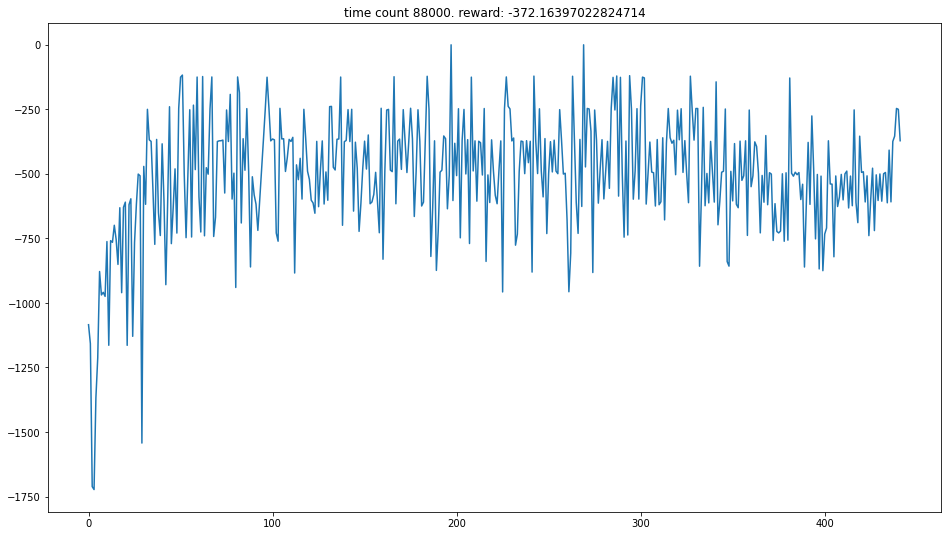

KeyboardInterrupt: 

In [5]:
# training loop
# env = ADSEnv()
env = gym.make("Pendulum-v0")
ou_noise = OUNoise(env.action_space)
rl = DDPG(env) # initiate the RL framework
rewards = []
time_count = 1

for i_episode in range(MAX_EPISODE):
    s = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    # while True:
    for step in range(MAX_STEP):  # only for demo
        if RENDER:
            env.render()    # show environment, only for demo
            
        a = rl.choose_action(s)
        a = ou_noise.choose_action(a, step)

        # select action and get feedback
        s_, r, done, info = env.step(a)

        # store transition experience into replay buffer
        rl.replay_buffer.store(s, a, r, s_, done)
        
        # learning
        rl.learn()
        
        if time_count % 1000 == 0:
            plot(time_count, rewards)
        
        # episode terminates, enter next episode
        if done: 
            break

        s = s_
        time_count += 1
        episode_reward += r
    
    rewards.append(episode_reward)
#     if i_episode % 50 == 0:
#          print("Episode finished after {} timesteps".format(time_count+1))
        
env.close()